In [ ]:
import sqlite3
import csv

'''
全局配置
'''
db_file = r"E:\gis\data\440100-trip_resident-20240914-clip\Mobile Signaling"
table_name = 'data'


In [ ]:
'''
测试
'''

conn = sqlite3.connect(db_file)
cursor = conn.cursor()

cursor.execute("SELECT * FROM data LIMIT 20")
rows = cursor.fetchall()

column_names = [description[0] for description in cursor.description]
print(", ".join(column_names))
for row in rows:
    print(row)

conn.close()


record_date, travel_period, purpose, city, o_lng, o_lat, d_lng, d_lat, user_quantity
(20240914, None, None, None, None, None, 112.9875, 23.4475, 856)
(20240914, None, None, None, None, None, 112.9925, 23.3975, 253)
(20240914, None, None, None, None, None, 112.9925, 23.4525, 3)
(20240914, None, None, None, None, None, 112.9975, 23.4475, 686)
(20240914, None, None, None, None, None, 113.0025, 23.3675, 92)
(20240914, None, None, None, None, None, 113.0025, 23.3925, 27)
(20240914, None, None, None, None, None, 113.0075, 23.3875, 718)
(20240914, None, None, None, None, None, 113.0275, 23.4525, 40)
(20240914, None, None, None, None, None, 113.0325, 23.4275, 235)
(20240914, None, None, None, None, None, 113.0375, 23.3175, 71)
(20240914, None, None, None, None, None, 113.0375, 23.4375, 24)
(20240914, None, None, None, None, None, 113.0425, 23.3175, 158)
(20240914, None, None, None, None, None, 113.0575, 23.3825, 45)
(20240914, None, None, None, None, None, 113.0675, 23.3925, 18)
(20240914, Non

In [ ]:
'''
查看行数
'''

with sqlite3.connect(db_file) as conn:
    cursor = conn.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_num = cursor.fetchone()[0]
print(f"表 '{table_name}' 的行数: {row_num:,}")


表 'data' 的行数: 6,277


In [ ]:
'''
合并相同坐标和user_quantity,删除o坐标和travel_period
'''

cursor.execute('''
            CREATE TEMP TABLE temp_travel_data AS
            SELECT 
                record_date,
                d_lng,
                d_lat,
                SUM(user_quantity) AS user_quantity
            FROM 
                data
            GROUP BY 
                record_date, d_lng, d_lat;
        ''')
cursor.execute('DELETE FROM data;')
cursor.execute('''
    INSERT INTO data (record_date, d_lng, d_lat, user_quantity)
    SELECT record_date, d_lng, d_lat, user_quantity FROM temp_travel_data;
''')
cursor.execute('DROP TABLE temp_travel_data;')

conn.commit()
print("数据处理完成并已提交。")
if conn:
    conn.close()
    print("数据库连接已关闭。")


数据处理完成并已提交。
数据库连接已关闭。


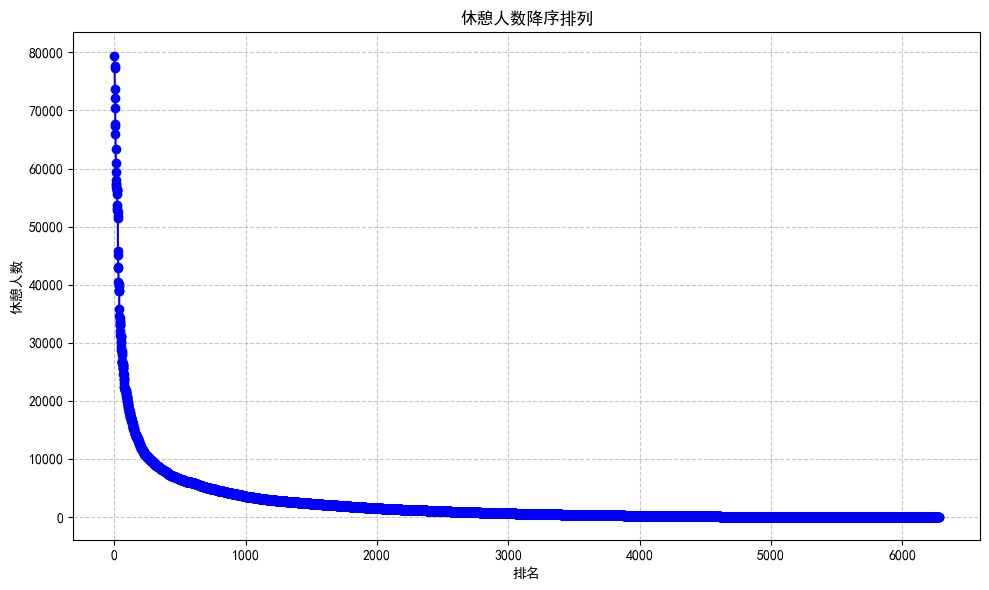

In [ ]:
'''
将user_quantity的值从大到小绘制
'''

import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect(db_file)
cursor = conn.cursor()
cursor.execute("SELECT user_quantity FROM data")
user_quantity_list = [row[0] for row in cursor.fetchall()]

sorted_data = sorted(user_quantity_list, reverse=True)
plt.rcParams["font.family"] = ["SimHei"]
# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(sorted_data) + 1), sorted_data, 'o-', color='b')
plt.title("休憩人数降序排列")
plt.xlabel("排名")
plt.ylabel("休憩人数")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [10]:
# 导出为csv
export_csvpath = 'export.csv'
with open(export_csvpath, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    with sqlite3.connect(db_file) as conn:
        cursor = conn.execute(f"SELECT * FROM {table_name}")
        batch_data = cursor.fetchmany(10000)
        writer.writerow([i[0] for i in cursor.description])
        count = 0
        while batch_data:
            writer.writerows(batch_data)
            batch_data = cursor.fetchmany(10000)
            count += len(batch_data)
        print(f'写入了{count}条数据')
        print(f'写入完成')


写入了0条数据
写入完成
